<a href="https://colab.research.google.com/github/SachinKumarare2020/DS_Data_Conversion/blob/main/Data_Conversion_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#2nd Code

import pandas as pd
import json
from datetime import datetime

def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def parse_datetime(date_str):
    try:
        return datetime.fromisoformat(date_str.replace('Z', '+00:00'))
    except ValueError:
        print(f"Unexpected datetime format: {date_str}")
        return None

def json_to_dataframe(data):
    records = []

    def extract_last_airport_code(itinerary):
        try:
            last_slice = itinerary['originDestinationInfo'][0]['flightSegmentInfo'][-1]
            return last_slice['arrival']['airportCode']
        except (IndexError, KeyError):
            return None

    def get_mid_destination_airport_code(itinerary):
        try:
            last_slice = itinerary['originDestinationInfo'][-1]['flightSegmentInfo'][-1]
            return last_slice['arrival']['airportCode']
        except (IndexError, KeyError):
            return None

    for itinerary in data['response'][0]['sliceItinerary']:

        outbound_flight_numbers = []
        return_flight_numbers = []

        segments = itinerary['originDestinationInfo'][0]['flightSegmentInfo']
        bound_duration = itinerary['originDestinationInfo'][0].get('boundDuration', 0)
        num_segments = len(segments)

        base_price = itinerary.get('pricingInfo', {}).get('totalPrice', None)
        trip_type = itinerary.get('tripType')

        first_departure_code = segments[0]['departure']['airportCode']
        last_arrival_code = extract_last_airport_code(itinerary)
        mid_destination_code = get_mid_destination_airport_code(itinerary)

        layover_airport_codes = []
        operating_carriers = []
        equipment_codes = []
        class_of_services = []
        booking_codes = []
        cabin_names = []
        flight_durations = []

        first_departure_date_time = None
        last_arrival_date_time = None
        rdeparture_date_time = None
        rlast_arrival_date_time = None

        for i, segment in enumerate(segments):
            departure_code = segment['departure']['airportCode']
            arrival_code = segment['arrival']['airportCode']
            layover_code = segment.get('layOver', {}).get('layoverAirportCode', None)

            if i == 0:
                first_departure_date_time = parse_datetime(segment['departureDateTime'])
            if i == num_segments - 1:
                last_arrival_date_time = parse_datetime(segment['arrivalDateTime'])

            if layover_code:
                if not layover_airport_codes or layover_code != layover_airport_codes[-1]:
                    layover_airport_codes.append(layover_code)

            outbound_flight_numbers.append(segment['flightNumber'])
            operating_carriers.append(segment['operatingCarrier']['code'])
            equipment_codes.append(segment['equipment']['code'])
            class_of_services.append(segment['classOfService'])
            booking_codes.append(segment['bookingCode'])
            cabin_names.append(segment['cabin']['cabinName'])

            flight_duration = int(segment.get('flightDuration', 0))
            flight_durations.append(flight_duration)

        if len(itinerary['originDestinationInfo']) > 1:
            rsegments = itinerary['originDestinationInfo'][1]['flightSegmentInfo']
            num_rsegments = len(rsegments)

            for i, rsegment in enumerate(rsegments):
                if i == 0:
                    rdeparture_code = rsegment['departure']['airportCode']
                    rdeparture_date_time = parse_datetime(rsegment['departureDateTime'])
                if i == num_rsegments - 1:
                    rarrival_code = rsegment['arrival']['airportCode']
                    rlast_arrival_date_time = parse_datetime(rsegment['arrivalDateTime'])

                return_flight_numbers.append(rsegment['flightNumber'])  # Collect all return flight numbers

        all_flight_numbers = outbound_flight_numbers + return_flight_numbers

        #print(outbound_flight_numbers)
        #print(return_flight_numbers)

        record = {
            'departure_airport_code': first_departure_code,
            'arrival_airport_code': mid_destination_code,
            'mid_destination_airport_code': last_arrival_code,
            'layover_airport_code': ','.join(layover_airport_codes),
            'departure_date_time': first_departure_date_time.isoformat() if first_departure_date_time else None,
            'arrival_date_time': last_arrival_date_time.isoformat() if last_arrival_date_time else None,
            'rdeparture_code': rdeparture_code if len(itinerary['originDestinationInfo']) > 1 else None,
            'rarrival_code': rarrival_code if len(itinerary['originDestinationInfo']) > 1 else None,
            'rdeparture_date_time': rdeparture_date_time.isoformat() if rdeparture_date_time else None,
            'rlast_arrival_date_time': rlast_arrival_date_time.isoformat() if rlast_arrival_date_time else None,
            'flight_number': ','.join(all_flight_numbers),
            'operating_carrier': ','.join(operating_carriers),
            'equipment_code': ','.join(equipment_codes),
            'class_of_service': ','.join(class_of_services),
            'booking_code': ','.join(booking_codes),
            'cabin_name': ','.join(cabin_names),
            'total_price': base_price,
            'tripType': trip_type,
            'total_flight_duration_minutes': bound_duration,
            'no_of_stops': len(layover_airport_codes)
        }
        records.append(record)
    return pd.DataFrame(records)

def save_dataframe_to_csv(df, output_file):
    df.to_csv(output_file, index=False)
    print(f"DataFrame saved to {output_file}")

file_path = '/content/sample_data/data.json'
output_file = '/content/sample_data/2.csv'

data = load_json(file_path)
df = json_to_dataframe(data)
save_dataframe_to_csv(df, output_file)
print(df)


DataFrame saved to /content/sample_data/2.csv
   departure_airport_code arrival_airport_code mid_destination_airport_code  \
0                     YUL                  YUL                          YVR   
1                     YUL                  YUL                          YVR   
2                     YUL                  YUL                          YVR   
3                     YUL                  YUL                          YVR   
4                     YUL                  YUL                          YVR   
..                    ...                  ...                          ...   
95                    YUL                  YUL                          YVR   
96                    YUL                  YUL                          YVR   
97                    YUL                  YUL                          YVR   
98                    YUL                  YUL                          YVR   
99                    YUL                  YUL                          YVR   

   la

In [ ]:
#combined CSV of Going and return Journey

import pandas as pd
import json
from datetime import datetime

def load_json(file_path):
    """
    Load JSON data from a file, with error handling for malformed JSON.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return json.load(file)
    except json.JSONDecodeError as e:
        print(f"JSON decoding error: {e}")
        return None
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

def parse_datetime(date_str):
    """
    Parse a datetime string into a datetime object.
    """
    try:
        return datetime.fromisoformat(date_str.replace('Z', '+00:00'))
    except ValueError:
        print(f"Unexpected datetime format: {date_str}")
        return None

def json_to_dataframes(data):
    """
    Convert JSON data to two separate DataFrames: one for outbound and one for return journeys.
    """
    outbound_records = []
    return_records = []

    def extract_last_airport_code(itinerary):
        try:
            last_slice = itinerary['originDestinationInfo'][0]['flightSegmentInfo'][-1]
            return last_slice['arrival']['airportCode']
        except (IndexError, KeyError):
            return None

    def get_mid_destination_airport_code(itinerary):
        try:
            last_slice = itinerary['originDestinationInfo'][-1]['flightSegmentInfo'][-1]
            return last_slice['arrival']['airportCode']
        except (IndexError, KeyError):
            return None

    for itinerary in data['response'][0]['sliceItinerary']:
        outbound_flight_numbers = []
        return_flight_numbers = []

        segments = itinerary['originDestinationInfo'][0]['flightSegmentInfo']
        bound_duration = itinerary['originDestinationInfo'][0].get('boundDuration', 0)
        num_segments = len(segments)

        base_price = itinerary.get('pricingInfo', {}).get('totalPrice', None)
        trip_type = itinerary.get('tripType')

        first_departure_code = segments[0]['departure']['airportCode']
        last_arrival_code = extract_last_airport_code(itinerary)
        mid_destination_code = get_mid_destination_airport_code(itinerary)

        layover_airport_codes = []
        operating_carriers = []
        equipment_codes = []
        class_of_services = []
        booking_codes = []
        cabin_names = []
        flight_durations = []

        first_departure_date_time = None
        last_arrival_date_time = None
        rdeparture_date_time = None
        rlast_arrival_date_time = None

        for i, segment in enumerate(segments):
            departure_code = segment['departure']['airportCode']
            arrival_code = segment['arrival']['airportCode']
            layover_code = segment.get('layOver', {}).get('layoverAirportCode', None)

            if i == 0:
                first_departure_date_time = parse_datetime(segment['departureDateTime'])
            if i == num_segments - 1:
                last_arrival_date_time = parse_datetime(segment['arrivalDateTime'])

            if layover_code:
                if not layover_airport_codes or layover_code != layover_airport_codes[-1]:
                    layover_airport_codes.append(layover_code)

            outbound_flight_numbers.append(segment['flightNumber'])
            operating_carriers.append(segment['operatingCarrier']['code'])
            equipment_codes.append(segment['equipment']['code'])
            class_of_services.append(segment['classOfService'])
            booking_codes.append(segment['bookingCode'])
            cabin_names.append(segment['cabin']['cabinName'])

            flight_duration = int(segment.get('flightDuration', 0))
            flight_durations.append(flight_duration)

        record_outbound = {
            'journey_type': 'outbound',
            'departure_airport_code': first_departure_code,
            'arrival_airport_code': mid_destination_code,
            'mid_destination_airport_code': last_arrival_code,
            'layover_airport_code': ','.join(layover_airport_codes),
            'departure_date_time': first_departure_date_time.isoformat() if first_departure_date_time else None,
            'arrival_date_time': last_arrival_date_time.isoformat() if last_arrival_date_time else None,
            'flight_number': ','.join(outbound_flight_numbers),
            'operating_carrier': ','.join(operating_carriers),
            'equipment_code': ','.join(equipment_codes),
            'class_of_service': ','.join(class_of_services),
            'booking_code': ','.join(booking_codes),
            'cabin_name': ','.join(cabin_names),
            'total_price': base_price,
            'tripType': trip_type,
            'total_flight_duration_minutes': bound_duration,
            'no_of_stops': len(layover_airport_codes)
        }
        outbound_records.append(record_outbound)

        if len(itinerary['originDestinationInfo']) > 1:
            rsegments = itinerary['originDestinationInfo'][1]['flightSegmentInfo']
            num_rsegments = len(rsegments)

            for i, rsegment in enumerate(rsegments):
                if i == 0:
                    rdeparture_code = rsegment['departure']['airportCode']
                    rdeparture_date_time = parse_datetime(rsegment['departureDateTime'])
                if i == num_rsegments - 1:
                    rarrival_code = rsegment['arrival']['airportCode']
                    rlast_arrival_date_time = parse_datetime(rsegment['arrivalDateTime'])

                return_flight_numbers.append(rsegment['flightNumber'])

            record_return = {
                'journey_type': 'return',
                'departure_airport_code': rdeparture_code if len(itinerary['originDestinationInfo']) > 1 else None,
                'arrival_airport_code': rarrival_code if len(itinerary['originDestinationInfo']) > 1 else None,
                'mid_destination_airport_code': None,
                'layover_airport_code': None,
                'departure_date_time': rdeparture_date_time.isoformat() if rdeparture_date_time else None,
                'arrival_date_time': rlast_arrival_date_time.isoformat() if rlast_arrival_date_time else None,
                'flight_number': ','.join(return_flight_numbers),
                'operating_carrier': None,
                'equipment_code': None,
                'class_of_service': None,
                'booking_code': None,
                'cabin_name': None,
                'total_price': None,
                'tripType': None,
                'total_flight_duration_minutes': None,
                'no_of_stops': None
            }
            return_records.append(record_return)

    outbound_df = pd.DataFrame(outbound_records)
    return_df = pd.DataFrame(return_records)

    combined_df = pd.concat([outbound_df, return_df], ignore_index=True)

    return combined_df

def save_dataframe_to_csv(df, output_file):
    """
    Save the DataFrame to a CSV file.
    """
    df.to_csv(output_file, index=False)
    print(f"DataFrame saved to {output_file}")


file_path = '/content/sample_data/data.json'
output_file = '/content/sample_data/combined_flights.csv'

data = load_json(file_path)

if data:
    df = json_to_dataframes(data)
    save_dataframe_to_csv(df, output_file)
    print(df)
else:
    print("Failed to load JSON data.")


DataFrame saved to /content/sample_data/combined_flights.csv
    journey_type departure_airport_code arrival_airport_code  \
0       outbound                    YUL                  YUL   
1       outbound                    YUL                  YUL   
2       outbound                    YUL                  YUL   
3       outbound                    YUL                  YUL   
4       outbound                    YUL                  YUL   
..           ...                    ...                  ...   
195       return                    YVR                  YUL   
196       return                    YVR                  YUL   
197       return                    YVR                  YUL   
198       return                    YVR                  YUL   
199       return                    YVR                  YUL   

    mid_destination_airport_code layover_airport_code  departure_date_time  \
0                            YVR              YEG,YYC  2024-08-20T22:00:00   
1             

<ipython-input-17-286968d2e665>:166: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([outbound_df, return_df], ignore_index=True)


In [ ]:
import pandas as pd
import json
from datetime import datetime

def load_json(file_path):
    """
    Load JSON data from a file, with error handling for malformed JSON.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return json.load(file)
    except json.JSONDecodeError as e:
        print(f"JSON decoding error: {e}")
        return None
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

def parse_datetime(date_str):
    """
    Parse a datetime string into a datetime object.
    """
    try:
        return datetime.fromisoformat(date_str.replace('Z', '+00:00'))
    except ValueError:
        print(f"Unexpected datetime format: {date_str}")
        return None

def json_to_dataframes(data):
    """
    Convert JSON data to two separate DataFrames: one for outbound and one for return journeys.
    """
    outbound_records = []
    return_records = []

    def extract_last_airport_code(itinerary):
        try:
            last_slice = itinerary['originDestinationInfo'][0]['flightSegmentInfo'][-1]
            return last_slice['arrival']['airportCode']
        except (IndexError, KeyError):
            return None

    def get_mid_destination_airport_code(itinerary):
        try:
            last_slice = itinerary['originDestinationInfo'][-1]['flightSegmentInfo'][-1]
            return last_slice['arrival']['airportCode']
        except (IndexError, KeyError):
            return None

    for itinerary in data['response'][0]['sliceItinerary']:
        outbound_flight_numbers = []
        return_flight_numbers = []

        segments = itinerary['originDestinationInfo'][0]['flightSegmentInfo']
        bound_duration = itinerary['originDestinationInfo'][0].get('boundDuration', 0)
        num_segments = len(segments)

        base_price = itinerary.get('pricingInfo', {}).get('totalPrice', None)
        trip_type = itinerary.get('tripType')

        first_departure_code = segments[0]['departure']['airportCode']
        last_arrival_code = extract_last_airport_code(itinerary)
        mid_destination_code = get_mid_destination_airport_code(itinerary)

        layover_airport_codes = []
        operating_carriers = []
        equipment_codes = []
        class_of_services = []
        booking_codes = []
        cabin_names = []
        flight_durations = []

        first_departure_date_time = None
        last_arrival_date_time = None
        rdeparture_date_time = None
        rlast_arrival_date_time = None

        for i, segment in enumerate(segments):
            departure_code = segment['departure']['airportCode']
            arrival_code = segment['arrival']['airportCode']
            layover_code = segment.get('layOver', {}).get('layoverAirportCode', None)

            if i == 0:
                first_departure_date_time = parse_datetime(segment['departureDateTime'])
            if i == num_segments - 1:
                last_arrival_date_time = parse_datetime(segment['arrivalDateTime'])

            if layover_code:
                if not layover_airport_codes or layover_code != layover_airport_codes[-1]:
                    layover_airport_codes.append(layover_code)

            outbound_flight_numbers.append(segment['flightNumber'])
            operating_carriers.append(segment['operatingCarrier']['code'])
            equipment_codes.append(segment['equipment']['code'])
            class_of_services.append(segment['classOfService'])
            booking_codes.append(segment['bookingCode'])
            cabin_names.append(segment['cabin']['cabinName'])

            flight_duration = int(segment.get('flightDuration', 0))
            flight_durations.append(flight_duration)

        record_outbound = {
            'journey_type': 'outbound',
            'departure_airport_code': first_departure_code,
            'arrival_airport_code': mid_destination_code,
            'mid_destination_airport_code': last_arrival_code,
            'layover_airport_code': ','.join(layover_airport_codes),
            'departure_date_time': first_departure_date_time.isoformat() if first_departure_date_time else None,
            'arrival_date_time': last_arrival_date_time.isoformat() if last_arrival_date_time else None,
            'flight_number': ','.join(outbound_flight_numbers),
            'operating_carrier': ','.join(operating_carriers),
            'equipment_code': ','.join(equipment_codes),
            'class_of_service': ','.join(class_of_services),
            'booking_code': ','.join(booking_codes),
            'cabin_name': ','.join(cabin_names),
            'total_price': base_price,
            'tripType': trip_type,
            'total_flight_duration_minutes': bound_duration,
            'no_of_stops': len(layover_airport_codes)
        }
        outbound_records.append(record_outbound)

        if len(itinerary['originDestinationInfo']) > 1:
            rsegments = itinerary['originDestinationInfo'][1]['flightSegmentInfo']
            num_rsegments = len(rsegments)

            for i, rsegment in enumerate(rsegments):
                if i == 0:
                    rdeparture_code = rsegment['departure']['airportCode']
                    rdeparture_date_time = parse_datetime(rsegment['departureDateTime'])
                if i == num_rsegments - 1:
                    rarrival_code = rsegment['arrival']['airportCode']
                    rlast_arrival_date_time = parse_datetime(rsegment['arrivalDateTime'])

                return_flight_numbers.append(rsegment['flightNumber'])

            record_return = {
                'journey_type': 'return',
                'departure_airport_code': rdeparture_code if len(itinerary['originDestinationInfo']) > 1 else None,
                'arrival_airport_code': rarrival_code if len(itinerary['originDestinationInfo']) > 1 else None,
                'mid_destination_airport_code': None,
                'layover_airport_code': None,
                'departure_date_time': rdeparture_date_time.isoformat() if rdeparture_date_time else None,
                'arrival_date_time': rlast_arrival_date_time.isoformat() if rlast_arrival_date_time else None,
                'flight_number': ','.join(return_flight_numbers),
                'operating_carrier': None,
                'equipment_code': None,
                'class_of_service': None,
                'booking_code': None,
                'cabin_name': None,
                'total_price': None,
                'tripType': None,
                'total_flight_duration_minutes': None,
                'no_of_stops': None         # Not available in return segments
            }
            return_records.append(record_return)

    outbound_df = pd.DataFrame(outbound_records)
    return_df = pd.DataFrame(return_records)

    combined_df = pd.concat([outbound_df, return_df], ignore_index=True)

    return combined_df

def save_dataframe_to_csv(df, output_file):
    """
    Save the DataFrame to a CSV file.
    """
    df.to_csv(output_file, index=False)
    print(f"DataFrame saved to {output_file}")

file_path = '/content/sample_data/data.json'
output_file = '/content/sample_data/combined_flights.csv'

data = load_json(file_path)

if data:
    df = json_to_dataframes(data)
    save_dataframe_to_csv(df, output_file)
    print(df)
else:
    print("Failed to load JSON data.")


DataFrame saved to /content/sample_data/combined_flights.csv
    journey_type departure_airport_code arrival_airport_code  \
0       outbound                    YUL                  YUL   
1       outbound                    YUL                  YUL   
2       outbound                    YUL                  YUL   
3       outbound                    YUL                  YUL   
4       outbound                    YUL                  YUL   
..           ...                    ...                  ...   
195       return                    YVR                  YUL   
196       return                    YVR                  YUL   
197       return                    YVR                  YUL   
198       return                    YVR                  YUL   
199       return                    YVR                  YUL   

    mid_destination_airport_code layover_airport_code  departure_date_time  \
0                            YVR              YEG,YYC  2024-08-20T22:00:00   
1             

<ipython-input-13-6786220f5150>:165: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([outbound_df, return_df], ignore_index=True)


In [4]:
#1. Return Type Data fetching Code
import pandas as pd
import pandas as pd
import json
from datetime import datetime

class CsvDataRTDto:
    def __init__(self):
        self.flight_name_o = ""
        self.flight_name_r = ""
        self.flight_number_o = ""
        self.flight_number_r = ""
        self.departure_date_o = ""
        self.arrival_date_o = ""
        self.departure_date_r = ""
        self.arrival_date_r = ""
        self.departure_airport_code_o = ""
        self.arrival_airport_code_o = ""
        self.departure_airport_code_r = ""
        self.arrival_airport_code_r = ""
        self.total_price = 0.0
        self.trip_type = "RT"
        self.flight_number_combine_o = ""
        self.flight_number_combine_r = ""
        self.name_of_stop_combine_o = ""
        self.name_of_stop_combine_r = ""
        self.layOver_o = ""
        self.layOver_r = ""
        self.cabinType_o = ""
        self.cabinType_r = ""
        self.jsondata = {}

def process_json_data(json_data_list):
    data_list = []

    for json_data in json_data_list:
        for res in json_data.get('response', []):
            for slice_itinerary in res.get('sliceItinerary', []):
                dto = CsvDataRTDto()
                dto.jsondata = res

                flight_name_o = ""
                flight_name_r = ""
                flight_number_o = ""
                flight_number_r = ""
                departure_date_o = ""
                departure_date_r = ""
                arrival_date_o = ""
                arrival_date_r = ""
                departure_airport_o = ""
                departure_airport_r = ""
                arrival_airport_o = ""
                arrival_airport_r = ""
                flight_number_set_o = set()
                flight_number_set_r = set()
                name_of_stops_o = set()
                name_of_stops_r = set()
                lay_over_o = 0
                lay_over_r = 0
                cabin_type_o = ""
                cabin_type_r = ""

                for j, origin_destination_info in enumerate(slice_itinerary.get('originDestinationInfo', [])):
                    flight_segments = origin_destination_info.get('flightSegmentInfo', [])

                    for i, flight_segment_info in enumerate(flight_segments):
                        if j == 0:

                            if i == 0:
                                flight_name_o = flight_segment_info.get('operatingCarrier', {}).get('name', "")
                                flight_number_o = flight_segment_info.get('flightNumber', "")
                                departure_date_o = flight_segment_info.get('departureDateTime', "")
                                departure_airport_o = flight_segment_info.get('departure', {}).get('airportCode', "")
                            if i == len(flight_segments) - 1:
                                arrival_date_o = flight_segment_info.get('arrivalDateTime', "")
                                arrival_airport_o = flight_segment_info.get('arrival', {}).get('airportCode', "")
                            flight_number_set_o.add(flight_segment_info.get('flightNumber', ""))
                            name_of_stops_o.add(flight_segment_info.get('departure', {}).get('airportCode', ""))
                            name_of_stops_o.add(flight_segment_info.get('arrival', {}).get('airportCode', ""))
                        elif j == 1:

                            if i == 0:
                                flight_name_r = flight_segment_info.get('operatingCarrier', {}).get('name', "")
                                flight_number_r = flight_segment_info.get('flightNumber', "")
                                departure_date_r = flight_segment_info.get('departureDateTime', "")
                                departure_airport_r = flight_segment_info.get('departure', {}).get('airportCode', "")
                            if i == len(flight_segments) - 1:
                                arrival_date_r = flight_segment_info.get('arrivalDateTime', "")
                                arrival_airport_r = flight_segment_info.get('arrival', {}).get('airportCode', "")
                            flight_number_set_r.add(flight_segment_info.get('flightNumber', ""))
                            name_of_stops_r.add(flight_segment_info.get('departure', {}).get('airportCode', ""))
                            name_of_stops_r.add(flight_segment_info.get('arrival', {}).get('airportCode', ""))

                dto.flight_name_o = flight_name_o
                dto.flight_number_o = flight_number_o
                dto.flight_name_r = flight_name_r
                dto.flight_number_r = flight_number_r
                dto.departure_date_o = departure_date_o
                dto.arrival_date_o = arrival_date_o
                dto.departure_date_r = departure_date_r
                dto.arrival_date_r = arrival_date_r
                dto.departure_airport_code_o = departure_airport_o
                dto.arrival_airport_code_o = arrival_airport_o
                dto.departure_airport_code_r = departure_airport_r
                dto.arrival_airport_code_r = arrival_airport_r
                dto.total_price = slice_itinerary.get('pricingInfo', {}).get('totalPrice', 0.0)
                dto.flight_number_combine_o = "-".join(flight_number_set_o)
                dto.flight_number_combine_r = "-".join(flight_number_set_r)
                dto.name_of_stop_combine_o = "-".join(name_of_stops_o)
                dto.name_of_stop_combine_r = "-".join(name_of_stops_r)
                dto.layOver_o = str(lay_over_o)
                dto.layOver_r = str(lay_over_r)
                dto.cabinType_o = cabin_type_o
                dto.cabinType_r = cabin_type_r

                data_list.append(dto.__dict__)
    return data_list

processed_data1 = pd.read_json('/content/sample_data/RT_Data.json')
processed_data1 = process_json_data([processed_data1])

df = pd.DataFrame(processed_data1)
df.to_csv('Return_Type_Data.csv') #download the csv converted file.
df

,flight_name_o,flight_name_r,flight_number_o,flight_number_r,departure_date_o,arrival_date_o,departure_date_r,arrival_date_r,departure_airport_code_o,arrival_airport_code_o,...,trip_type,flight_number_combine_o,flight_number_combine_r,name_of_stop_combine_o,name_of_stop_combine_r,layOver_o,layOver_r,cabinType_o,cabinType_r,jsondata
0,Westjet,Westjet,5472,5767,2024-08-20T22:00:00,2024-08-21T07:30:00,2024-09-01T06:30:00,2024-09-01T15:18:00,YUL,YVR,...,RT,103-5250-5472,5767-548,YYC-YVR-YUL-YEG,YVR-YUL-YEG,0,0,,,"{'status': {'type': 'SUCCESS', 'totalItinerari..."
1,Westjet,Westjet,5472,5767,2024-08-20T22:00:00,2024-08-21T08:30:00,2024-09-01T06:30:00,2024-09-01T15:18:00,YUL,YVR,...,RT,105-5250-5472,5767-548,YYC-YVR-YUL-YEG,YVR-YUL-YEG,0,0,,,"{'status': {'type': 'SUCCESS', 'totalItinerari..."
2,Westjet,Westjet,5472,5767,2024-08-20T22:00:00,2024-08-21T09:30:00,2024-09-01T06:30:00,2024-09-01T15:18:00,YUL,YVR,...,RT,107-5250-5472,5767-548,YYC-YVR-YUL-YEG,YVR-YUL-YEG,0,0,,,"{'status': {'type': 'SUCCESS', 'totalItinerari..."
3,Westjet,Westjet,5472,5767,2024-08-20T22:00:00,2024-08-21T04:45:00,2024-09-01T06:30:00,2024-09-01T15:18:00,YUL,YVR,...,RT,5472-5210,5767-548,YVR-YUL-YEG,YVR-YUL-YEG,0,0,,,"{'status': {'type': 'SUCCESS', 'totalItinerari..."
4,Westjet,Westjet,5472,5516,2024-08-20T22:00:00,2024-08-21T04:45:00,2024-09-01T13:00:00,2024-09-02T02:15:00,YUL,YVR,...,RT,5472-5210,5516-739-5478,YVR-YUL-YEG,YYC-YVR-YUL-YWG,0,0,,,"{'status': {'type': 'SUCCESS', 'totalItinerari..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Air Canada,Air Canada,8015,314,2024-08-20T18:15:00,2024-08-21T00:03:00,2024-09-01T22:50:00,2024-09-02T06:42:00,YUL,YVR,...,RT,347-8015,314,YVR-YUL-YOW,YVR-YUL,0,0,,,"{'status': {'type': 'SUCCESS', 'totalItinerari..."
96,Air Canada,Air Canada,7773,302,2024-08-21T05:00:00,2024-08-21T09:22:00,2024-09-01T07:50:00,2024-09-01T15:42:00,YUL,YVR,...,RT,101-7773,302,YVR-YUL-YYZ,YVR-YUL,0,0,,,"{'status': {'type': 'SUCCESS', 'totalItinerari..."
97,Air Canada,Air Canada,7773,306,2024-08-21T05:00:00,2024-08-21T09:22:00,2024-09-01T11:25:00,2024-09-01T19:16:00,YUL,YVR,...,RT,101-7773,306,YVR-YUL-YYZ,YVR-YUL,0,0,,,"{'status': {'type': 'SUCCESS', 'totalItinerari..."
98,Air Canada,Air Canada,7773,308,2024-08-21T05:00:00,2024-08-21T09:22:00,2024-09-01T13:10:00,2024-09-01T21:01:00,YUL,YVR,...,RT,101-7773,308,YVR-YUL-YYZ,YVR-YUL,0,0,,,"{'status': {'type': 'SUCCESS', 'totalItinerari..."


In [6]:
#2. Open_Job Type Data fetching Code

import pandas as pd
import json
from datetime import datetime

class CsvDataRTDto:
    def __init__(self):
        self.jsondata = None
        self.flight_name_o = ""
        self.flight_number_o = ""
        self.flight_name_r = ""
        self.flight_number_r = ""
        self.departure_date_o = ""
        self.arrival_date_o = ""
        self.departure_date_r = ""
        self.arrival_date_r = ""
        self.departure_airport_code_o = ""
        self.arrival_airport_code_o = ""
        self.departure_airport_code_r = ""
        self.arrival_airport_code_r = ""
        self.total_price = 0.0
        self.trip_type = "OJ"
        self.flight_number_combine_o = ""
        self.flight_number_combine_r = ""
        self.name_of_stop_combine_o = ""
        self.name_of_stop_combine_r = ""
        self.layOver_o = ""
        self.layOver_r = ""
        self.total_flight_duration_o = ""
        self.total_flight_duration_r = ""
        self.cabinType_o = ""
        self.cabinType_r = ""

def process_json_data(json_data_list):
    data_list = []

    for json_data in json_data_list:
        for res in json_data.get('response', []):
            for slice_itinerary in res.get('sliceItinerary', []):
                dto = CsvDataRTDto()
                dto.jsondata = json.dumps(res)

                flight_name_o = ""
                flight_name_r = ""
                flight_number_o = ""
                flight_number_r = ""
                departure_date_o = ""
                departure_date_r = ""
                arrival_date_o = ""
                arrival_date_r = ""
                departure_airport_o = ""
                departure_airport_r = ""
                arrival_airport_o = ""
                arrival_airport_r = ""
                flight_number_set_o = set()
                flight_number_set_r = set()
                name_of_stops_o = set()
                name_of_stops_r = set()
                lay_over_o = 0
                lay_over_r = 0
                total_flight_duration_o = 0
                total_flight_duration_r = 0
                cabin_type_o = ""
                cabin_type_r = ""

                previous_arrival_time_o = None
                previous_arrival_time_r = None

                for j, origin_destination_info in enumerate(slice_itinerary.get('originDestinationInfo', [])):
                    flight_segments = origin_destination_info.get('flightSegmentInfo', [])

                    for i, flight_segment_info in enumerate(flight_segments):
                        flight_number = flight_segment_info.get('flightNumber', "")
                        operating_carrier = flight_segment_info.get('operatingCarrier', {}).get('name', "")
                        departure_datetime = flight_segment_info.get('departureDateTime', "")
                        arrival_datetime = flight_segment_info.get('arrivalDateTime', "")
                        departure_airport = flight_segment_info.get('departure', {}).get('airportCode', "")
                        arrival_airport = flight_segment_info.get('arrival', {}).get('airportCode', "")
                        cabin_type = flight_segment_info.get('cabin', {}).get('cabinName', "")
                        flight_duration = flight_segment_info.get('flightDuration', 0)

                        if j == 0:  # Outbound leg
                            if i == 0:
                                flight_name_o = operating_carrier
                                flight_number_o = flight_number
                                departure_date_o = departure_datetime
                                departure_airport_o = departure_airport

                            if i == len(flight_segments) - 1:
                                arrival_date_o = arrival_datetime
                                arrival_airport_o = arrival_airport

                            flight_number_set_o.add(flight_number)
                            name_of_stops_o.add(departure_airport)
                            name_of_stops_o.add(arrival_airport)

                            if previous_arrival_time_o and departure_datetime:
                                layover_time = datetime.fromisoformat(departure_datetime) - datetime.fromisoformat(previous_arrival_time_o)
                                lay_over_o += layover_time.total_seconds() / 60

                            previous_arrival_time_o = arrival_datetime

                            if flight_duration:
                                total_flight_duration_o += float(flight_duration)

                            if cabin_type_o == "":
                                cabin_type_o = cabin_type

                        elif j == 1:  # Return leg
                            if i == 0:
                                flight_name_r = operating_carrier
                                flight_number_r = flight_number
                                departure_date_r = departure_datetime
                                departure_airport_r = departure_airport
                                cabin_type_r = cabin_type

                            if i == len(flight_segments) - 1:
                                arrival_date_r = arrival_datetime
                                arrival_airport_r = arrival_airport

                            flight_number_set_r.add(flight_number)
                            name_of_stops_r.add(departure_airport)
                            name_of_stops_r.add(arrival_airport)

                            if previous_arrival_time_r and departure_datetime:
                                layover_time = datetime.fromisoformat(departure_datetime) - datetime.fromisoformat(previous_arrival_time_r)
                                lay_over_r += layover_time.total_seconds() / 60

                            previous_arrival_time_r = arrival_datetime

                            if flight_duration:
                                total_flight_duration_r += float(flight_duration)

                            if cabin_type_r == "":
                                cabin_type_r = cabin_type

                dto.flight_name_o = flight_name_o
                dto.flight_number_o = flight_number_o
                dto.flight_name_r = flight_name_r
                dto.flight_number_r = flight_number_r
                dto.departure_date_o = departure_date_o
                dto.arrival_date_o = arrival_date_o
                dto.departure_date_r = departure_date_r
                dto.arrival_date_r = arrival_date_r
                dto.departure_airport_code_o = departure_airport_o
                dto.arrival_airport_code_o = arrival_airport_o
                dto.departure_airport_code_r = departure_airport_r
                dto.arrival_airport_code_r = arrival_airport_r
                dto.total_price = slice_itinerary.get('pricingInfo', {}).get('totalPrice', 0.0)
                dto.trip_type = "OJ"
                dto.flight_number_combine_o = "-".join(flight_number_set_o)
                dto.flight_number_combine_r = "-".join(flight_number_set_r)
                dto.name_of_stop_combine_o = "-".join(name_of_stops_o)
                dto.name_of_stop_combine_r = "-".join(name_of_stops_r)
                dto.layOver_o = str(lay_over_o)
                dto.layOver_r = str(lay_over_r)
                dto.total_flight_duration_o = str(total_flight_duration_o)
                dto.total_flight_duration_r = str(total_flight_duration_r)
                dto.cabinType_o = cabin_type_o
                dto.cabinType_r = cabin_type_r

                data_list.append(dto.__dict__)
    return data_list

try:
    with open('/content/sample_data/OJ_Data.json', 'r') as file:
        json_data = json.load(file)
        processed_data1 = process_json_data([json_data])
        df = pd.DataFrame(processed_data1)

        columns_order = [
            'flight_name_o', 'flight_name_r', 'flight_number_o', 'flight_number_r',
            'departure_date_o', 'arrival_date_o', 'departure_date_r', 'arrival_date_r',
            'departure_airport_code_o', 'arrival_airport_code_o', 'departure_airport_code_r',
            'arrival_airport_code_r', 'total_price', 'trip_type', 'flight_number_combine_o',
            'flight_number_combine_r', 'name_of_stop_combine_o', 'name_of_stop_combine_r',
            'layOver_o', 'layOver_r','total_flight_duration_o','total_flight_duration_r',
            'cabinType_o', 'cabinType_r', 'jsondata'
        ]
        df = df[columns_order]

        df.to_csv('Open_Job_converted_file.csv', index=False)

    print("Data processed and saved to 'Open_Job_converted_file.csv'.")
except FileNotFoundError:
    print("The file 'OJ_Data.json' was not found.")
except json.JSONDecodeError:
    print("Error decoding JSON from the file.")
except Exception as e:
    print(f"An error occurred: {e}")

df

Data processed and saved to 'Open_Job_converted_file.csv'.


,flight_name_o,flight_name_r,flight_number_o,flight_number_r,departure_date_o,arrival_date_o,departure_date_r,arrival_date_r,departure_airport_code_o,arrival_airport_code_o,...,flight_number_combine_r,name_of_stop_combine_o,name_of_stop_combine_r,layOver_o,layOver_r,total_flight_duration_o,total_flight_duration_r,cabinType_o,cabinType_r,jsondata
0,Alitalia,Air Canada,1156,8656,2024-09-15T15:15:00,2024-09-16T15:10:00,2024-09-17T20:55:00,2024-09-18T14:10:00,REG,YWG,...,8656-3425-522,YWG-BRU-REG-YUL-FCO,ORD-YVR-YUL-PDX,1005.0,401.0,850.0,454.0,Economy,Economy,"{""status"": {""type"": ""SUCCESS"", ""totalItinerari..."
1,Alitalia,Air Canada,1156,8656,2024-09-15T15:15:00,2024-09-16T15:10:00,2024-09-17T20:55:00,2024-09-18T11:45:00,REG,YWG,...,8656-3425-520,YWG-BRU-REG-YUL-FCO,ORD-YVR-YUL-PDX,1005.0,256.0,850.0,454.0,Economy,Economy,"{""status"": {""type"": ""SUCCESS"", ""totalItinerari..."
2,Alitalia,Air Canada,1156,8656,2024-09-15T15:15:00,2024-09-16T15:10:00,2024-09-17T20:55:00,2024-09-18T11:45:00,REG,YWG,...,8656-3425-520,FRA-YWG-REG-YUL-FCO,ORD-YVR-YUL-PDX,985.0,256.0,870.0,454.0,Economy,Economy,"{""status"": {""type"": ""SUCCESS"", ""totalItinerari..."
3,Alitalia,Air Canada,1156,8656,2024-09-15T15:15:00,2024-09-16T15:10:00,2024-09-17T20:55:00,2024-09-18T14:10:00,REG,YWG,...,8656-3425-522,FRA-YWG-REG-YUL-FCO,ORD-YVR-YUL-PDX,985.0,401.0,870.0,454.0,Economy,Economy,"{""status"": {""type"": ""SUCCESS"", ""totalItinerari..."
4,Alitalia,United Airlines,1156,1279,2024-09-15T15:15:00,2024-09-16T15:10:00,2024-09-17T23:35:00,2024-09-18T11:45:00,REG,YWG,...,1279-520,YWG-BRU-REG-YUL-FCO,ORD-YVR-YUL,1005.0,170.0,850.0,380.0,Economy,Economy,"{""status"": {""type"": ""SUCCESS"", ""totalItinerari..."
5,Alitalia,United Airlines,1156,1279,2024-09-15T15:15:00,2024-09-16T15:10:00,2024-09-17T23:35:00,2024-09-18T11:45:00,REG,YWG,...,1279-520,FRA-YWG-REG-YUL-FCO,ORD-YVR-YUL,985.0,170.0,870.0,380.0,Economy,Economy,"{""status"": {""type"": ""SUCCESS"", ""totalItinerari..."
6,Alitalia,Air Canada,1156,1048,2024-09-15T15:15:00,2024-09-16T15:10:00,2024-09-17T08:15:00,2024-09-17T21:29:00,REG,YWG,...,3053-1048,YWG-BRU-REG-YUL-FCO,ORD-YVR-YUL,1005.0,214.0,850.0,400.0,Economy,Economy,"{""status"": {""type"": ""SUCCESS"", ""totalItinerari..."
7,Alitalia,Air Canada,1156,1048,2024-09-15T15:15:00,2024-09-16T15:10:00,2024-09-17T08:15:00,2024-09-17T21:29:00,REG,YWG,...,3053-1048,FRA-YWG-REG-YUL-FCO,ORD-YVR-YUL,985.0,214.0,870.0,400.0,Economy,Economy,"{""status"": {""type"": ""SUCCESS"", ""totalItinerari..."
8,Alitalia,Air Canada,1156,304,2024-09-15T15:15:00,2024-09-16T15:10:00,2024-09-17T09:10:00,2024-09-17T16:51:00,REG,YWG,...,304,YWG-BRU-REG-YUL-FCO,YVR-YUL,1005.0,0,850.0,281.0,Economy,Economy,"{""status"": {""type"": ""SUCCESS"", ""totalItinerari..."
9,Alitalia,Air Canada,1156,306,2024-09-15T15:15:00,2024-09-16T15:10:00,2024-09-17T11:25:00,2024-09-17T19:14:00,REG,YWG,...,306,YWG-BRU-REG-YUL-FCO,YVR-YUL,1005.0,0,850.0,289.0,Economy,Economy,"{""status"": {""type"": ""SUCCESS"", ""totalItinerari..."


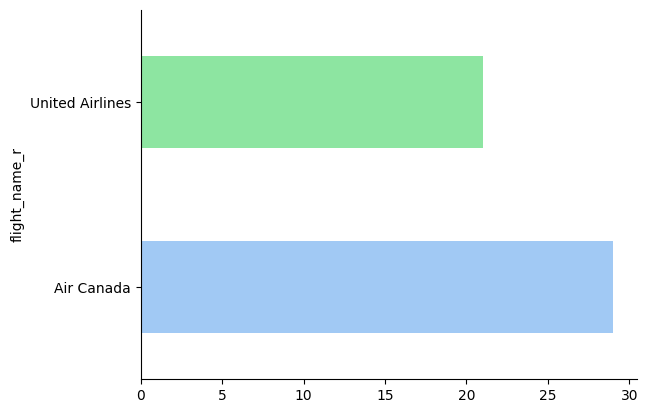

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('flight_name_r').size().plot(kind='barh', color=sns.color_palette("pastel6").as_hex())
plt.gca().spines[['top', 'right',]].set_visible(False)
#print(sns.color_palette("pastel6").as_hex())


<ipython-input-37-61c83f0d6114>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = df, x = 'total_price', y = 'flight_name_r', palette = 'mako_r')


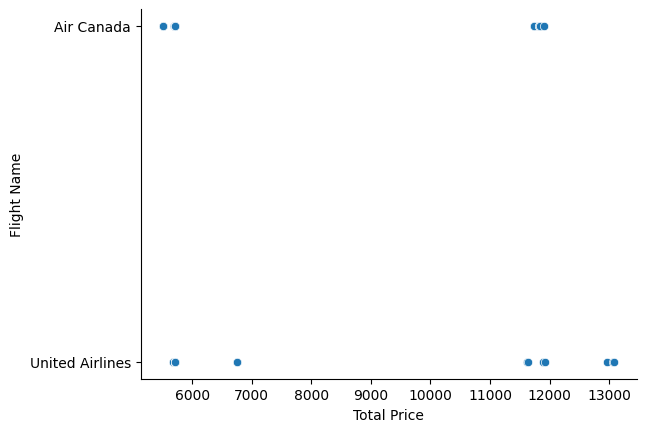

In [37]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.scatterplot(data = df, x = 'total_price', y = 'flight_name_r', palette = 'mako_r')

plt.gca().spines[['top', 'right']].set_visible(False)

#sns.scatterplot(data=df, x='total price', y='flight_name_r', palette='mako_r')

# plt.gca().spines[['top', 'right']].set_visible(False)
# plt.title('Total Price vs Flight Name')  # Add a title if appropriate
plt.xlabel('Total Price')
plt.ylabel('Flight Name')
plt.show()


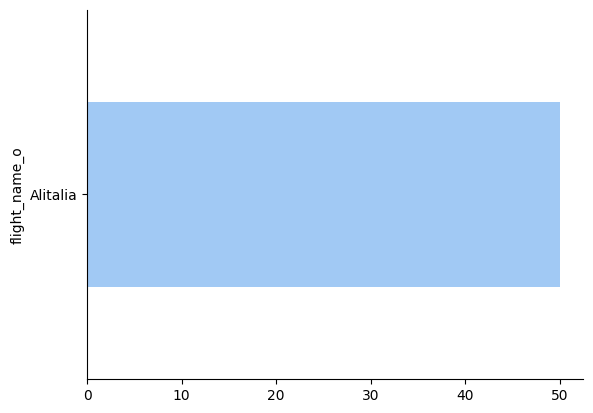

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('flight_name_o').size().plot(kind='barh', color=sns.color_palette("pastel6").as_hex())
plt.gca().spines[['top', 'right',]].set_visible(False)
# print(sns.color_palette("pastel6").as_hex())


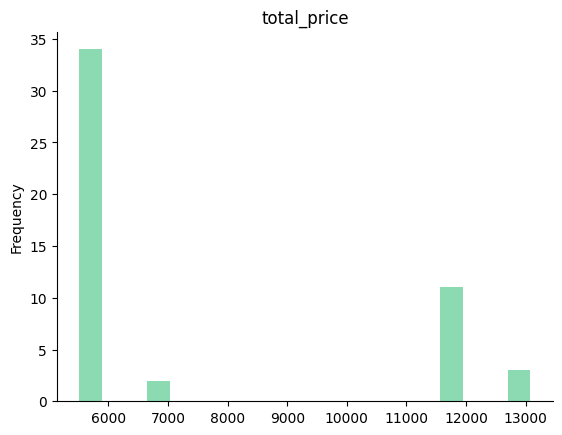

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

df['total_price'].plot(kind='hist', color = sns.color_palette('mako_r'), bins=20, title='total_price')

plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

<ipython-input-21-0e18a6ed989a>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='total_price', y='cabinType_o', palette='mako_r')


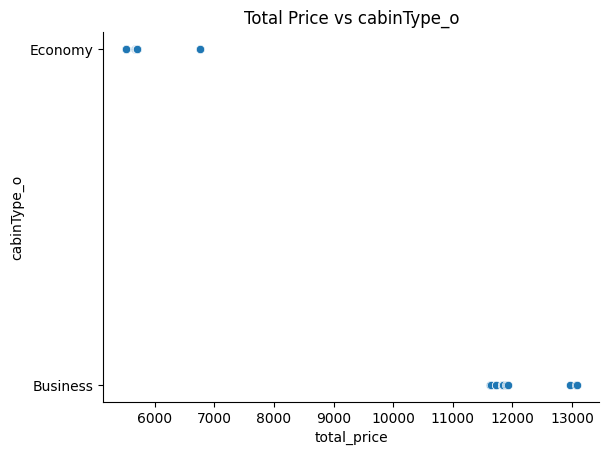

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns

# plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='total_price', y='cabinType_o', palette='mako_r')

plt.title('Total Price vs cabinType_o').figsize=(10,6)
plt.show()



<ipython-input-23-87c75710ad11>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='total_price', y='cabinType_r', palette='mako_r')


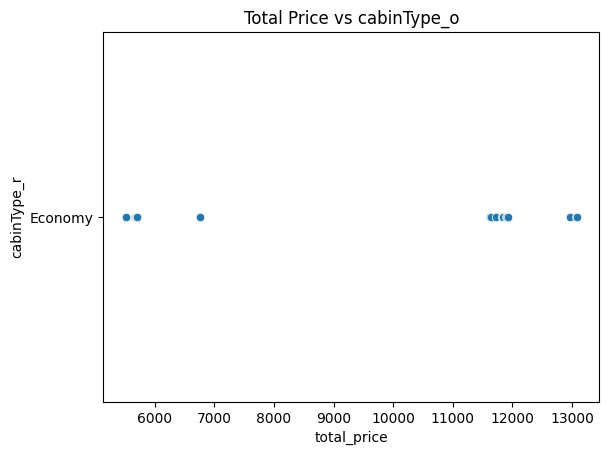

In [23]:
sns.scatterplot(data=df, x='total_price', y='cabinType_r', palette='mako_r')
plt.title('Total Price vs cabinType_o').figsize=(10,6)
plt.show()
